In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def velocity_right_encoder(counts, timestamps):
    delta_t = timestamps[1:] - timestamps[:-1]
    delta_t = [timestamps[1] - timestamps[0]] + list(delta_t)
    return ((counts[0, :] + counts[2, :]) / 2 * 0.0022) / delta_t

def velocity_left_encoder(counts, timestamps):
    delta_t = timestamps[1:] - timestamps[:-1]
    delta_t = [timestamps[1] - timestamps[0]] + list(delta_t)
    return ((counts[1, :] + counts[3, :]) / 2 * 0.0022) / delta_t

def sync_time_stamps(t1, t2):
    t1_synced = []
    ind = 0
    for i in range(len(t1)):
        while(t2[ind] < t1[i] and ind < len(t2) - 1):
            ind += 1
        t1_synced.append(ind)
    return np.array(t1_synced)

In [ ]:
dataset = 20

with np.load("../data/Encoders%d.npz"%dataset) as data:
    print(data)
    encoder_counts = data["counts"] # 4 x n encoder counts
    encoder_stamps = data["time_stamps"] # encoder time stamps

NpzFile '../data/Encoders20.npz' with keys: counts, time_stamps


In [7]:
with np.load("../data/Imu%d.npz"%dataset) as data:
    print(data)
    imu_angular_velocity = data["angular_velocity"] # angular velocity in rad/sec
    imu_linear_acceleration = data["linear_acceleration"] # accelerations in gs (gravity acceleration scaling)
    imu_stamps = data["time_stamps"]  # acquisition times of the imu measurements

NpzFile '../data/Imu20.npz' with keys: angular_velocity, linear_acceleration, time_stamps


In [8]:
synced_encoder_stamps = sync_time_stamps(imu_stamps, encoder_stamps)

v_left = velocity_left_encoder(encoder_counts, encoder_stamps)
v_right = velocity_right_encoder(encoder_counts, encoder_stamps)

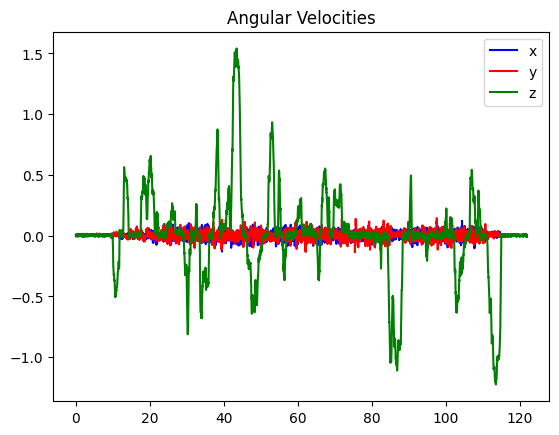

In [9]:
# Plotting the x, y, z velocities
plt.title("Angular Velocities")
plt.plot(imu_stamps - imu_stamps[0], imu_angular_velocity[0], color='blue')
plt.plot(imu_stamps - imu_stamps[0], imu_angular_velocity[1], color='red')
plt.plot(imu_stamps - imu_stamps[0], imu_angular_velocity[2], color='green')
plt.legend(['x', 'y', 'z'])
plt.show()

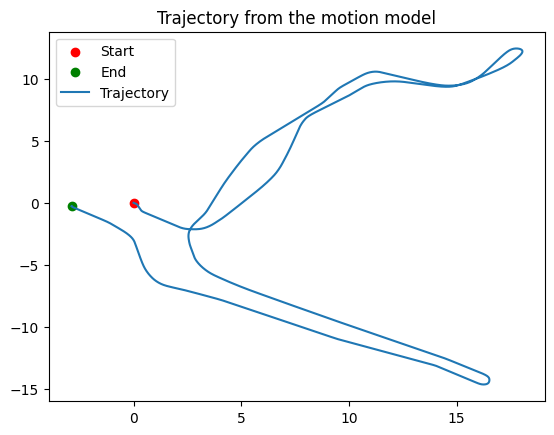

In [10]:
# Motion model
axel_length = 0.31115 # meters
wheel_diameter = 0.254 # meters

def motion_model(pose, v, omega, dt):
    x, y, theta = pose
    x += v * np.cos(theta) * dt
    y += v * np.sin(theta) * dt
    theta += omega * dt
    return np.array([x, y, theta])

pose = np.zeros((3))

x_traj = [0]
y_traj = [0]

for i in range(len(imu_angular_velocity[2])):
    omega = imu_angular_velocity[2][i] # yaw angular velocity
    dt = imu_stamps[i] - imu_stamps[i - 1]
    encoder_ind = synced_encoder_stamps[i]
    v = (v_left[encoder_ind] + v_right[encoder_ind]) / 2
    pose = motion_model(pose, v, omega, dt)

    x_traj.append(pose[0])
    y_traj.append(pose[1])

# Beginning point
plt.scatter(0, 0, c='r')
# Ending point
plt.scatter(pose[0], pose[1], c='g')
plt.title("Trajectory from the motion model")
plt.plot(x_traj, y_traj)
plt.legend(["Start", "End", "Trajectory"])
plt.show()